# Hypertune cifar10

In [2]:
DATADIR = ("data/raw/cifar10/")
TUNEDIR = ("hypertune")
from loguru import logger
import ray


In [3]:
# from torchvision import datasets, transforms
# from loguru import logger
from pathlib import Path

# # Ensure the data directory exists before downloading dataset
data_dir = Path(DATADIR).resolve()
if not data_dir.exists():
    data_dir.mkdir(parents=True)
    logger.info(f"Created {data_dir}")

tune_dir = Path(TUNEDIR).resolve()
if not tune_dir.exists():
    tune_dir.mkdir(parents=True)
    logger.info(f"Created {tune_dir}")

# # Create transformer to convert images to tensors
# transformer = transforms.Compose([transforms.ToTensor()])

# # Download CIFAR10 dataset
# train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transformer)
# test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transformer)

# logger.info(
#     f"Dataset is now available:\n"
#     f"TRAIN: {train_dataset}\n"
#     f"TEST: {test_dataset}"
# )

In [4]:
# train_dataset.classes

In [5]:
# from torch.utils.data import DataLoader

# # Create data loaders for training and testing
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Inspect the shape of a batch of training data
# for images, labels in train_loader:
#     logger.info(f"Image batch dimensions: {images.shape}")
#     logger.info(f"Image label dimensions: {labels.shape}")
#     break

In [6]:
def get_data_loaders(batch_size, data_dir):
    from filelock import FileLock
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader

    with FileLock(data_dir / ".lock"):
        # Create transformer to convert images to tensors
        transformer = transforms.Compose([transforms.ToTensor()])

        # Download CIFAR10 dataset
        train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transformer, )
        test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transformer)

        # Create data loaders for training and testing
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    return train_loader, test_loader

def get_data_loaders_transforms(batch_size, data_dir):
    from filelock import FileLock
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader

    with FileLock(data_dir / ".lock"):
        # Create transformer to convert images to tensors
        transformer = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # random zoom
            transforms.RandomHorizontalFlip(),                   # random flip
            transforms.ToTensor()
        ])

        # Download CIFAR10 dataset
        train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transformer, )
        test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transformer)

        # Create data loaders for training and testing
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    return train_loader, test_loader

In [7]:
import torch
from pathlib import Path

config = {
    # Fixed parameters
    "epochs": 5,
    "data_dir": Path(DATADIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 20,
    "hidden_size": 128,
    "dropout": 0,
    "num_layers": 5,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    # "scheduler": torch.optim.lr_scheduler.LRScheduler,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu", 
}

In [8]:
# Setup for simple neural network with learning curve plotting

import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    """
    A simple feedforward neural network for image classification.

    Args:
        input_size (int): Number of input channels (e.g., 3 for RGB images).
        hidden_size (int): Number of units in hidden layers.
        output_size (int): Number of output classes.
        dropout (float): Dropout probability for regularization.
        num_layers (int): Number of hidden layers.

    Methods:
        forward(x): Forward pass through the network.
        summary(): Prints a summary of the network architecture.
        plot_learning_curve(): Plots the learning curve (loss and accuracy).
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers, use_residual=False, use_batchnorm=False):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.use_residual = use_residual
        self.use_batchnorm = use_batchnorm
        # For learning curve
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        layers = []
        # Flatten input image
        layers.append(nn.Flatten())
        # First linear layer from input to hidden
        layers.append(nn.Linear(input_size * 32 * 32, hidden_size))
        if self.use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        # Additional hidden layers with optional residual and batchnorm
        for i in range(num_layers - 1):
            linear = nn.Linear(hidden_size, hidden_size)
            block = [linear]
            if self.use_batchnorm:
                block.append(nn.BatchNorm1d(hidden_size))
            block.append(nn.ReLU())
            block.append(nn.Dropout(dropout))
            if self.use_residual:
                # Residual block as a custom nn.Module
                block = [ResidualBlock(hidden_size, block)]
            layers.extend(block)

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)


    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size, 32, 32).

        Returns:
            torch.Tensor: Output logits.
        """
        return self.network(x) 

    def summary(self):
        """
        Prints a summary of the network architecture using torchsummary.
        """
        summary(self.network, (self.input_size, 32, 32))

    def plot_learning_curve(self):
        """
        Plots the learning curve (loss and accuracy).
        """
        epochs = range(1, len(self.train_losses) + 1)
        fig, ax1 = plt.subplots()
        ax1.plot(epochs, self.train_losses, 'b-', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.plot(epochs, self.train_accuracies, 'b--', label='Train Acc')
        ax2.plot(epochs, self.val_accuracies, 'r--', label='Val Acc')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='upper right')
        plt.title('Learning Curve')
        plt.show()

class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, block_layers):
        super().__init__()
        self.block = nn.Sequential(*block_layers)
        self.hidden_size = hidden_size

    def forward(self, x):
        return x + self.block(x)


model_NN = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"]
)
model_NN_with_residual = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"],
    use_residual=True
)
model_NN_with_batchnorm = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"],
    use_batchnorm=True
)

# Show a summary of the model architecture
model_NN.summary(); model_NN_with_residual.summary(); model_NN_with_batchnorm.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 3072]                --
├─Linear: 1-2                            [-1, 128]                 393,344
├─ReLU: 1-3                              [-1, 128]                 --
├─Dropout: 1-4                           [-1, 128]                 --
├─Linear: 1-5                            [-1, 128]                 16,512
├─ReLU: 1-6                              [-1, 128]                 --
├─Dropout: 1-7                           [-1, 128]                 --
├─Linear: 1-8                            [-1, 128]                 16,512
├─ReLU: 1-9                              [-1, 128]                 --
├─Dropout: 1-10                          [-1, 128]                 --
├─Linear: 1-11                           [-1, 128]                 16,512
├─ReLU: 1-12                             [-1, 128]                 --
├─Dropout: 1-13                          [-1, 128]                 -

In [9]:
from tqdm import tqdm

def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_evaluate(model, config, logger):
    train_loader, test_loader = get_data_loaders(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_accuracy = evaluate(model, test_loader, loss_fn, device)

        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)

        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")
    
    return model.train_losses[-1], model.val_losses[-1], model.val_accuracies[-1]


In [10]:
# train_and_evaluate(model_NN, config, logger)
# model_NN.plot_learning_curve()

In [11]:
# train_and_evaluate(model_NN_with_residual, config, logger)
# model_NN_with_residual.plot_learning_curve()

In [12]:
# train_and_evaluate(model_NN_with_batchnorm, config, logger)

In [13]:
# from mltrainer import Trainer, ReportTypes, TrainerSettings

# model_NN2 = SimpleNN(
#     input_size=config["input_size"],
#     hidden_size=config["hidden_size"],
#     output_size=config["output_size"],
#     dropout=config["dropout"],
#     num_layers=config["num_layers"]
# )

# model_NN2.to(device)

# trainer = Trainer(
#     model=model_NN2,
#     settings=TrainerSettings(
#         epochs=config["epochs"],
#         metrics=[config["metrics"]],
#         logdir=Path("./logs"),
#         train_steps=len(train_loader),
#         valid_steps=len(test_loader),
#         reporttypes=[ReportTypes.TOML],
#         scheduler_kwargs={"patience": 5},
#         earlystop_kwargs={"patience": 5},
#     ),
#     loss_fn=config["loss_fn"],
#     optimizer=torch.optim.Adam,
#     traindataloader=train_loader,
#     validdataloader=test_loader,
#     scheduler=config["scheduler"],
#     device=device,
# )
# trainer.loop()

In [14]:
config2 = {
    # Fixed parameters
    "epochs": 5,
    "data_dir": Path(DATADIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 20,
    "hidden_size": 128,
    "dropout": 0,
    "num_fully_connected_layers": 2,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    # "scheduler": torch.optim.lr_scheduler.LRScheduler,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # convolutional layer parameters
    "num_conv_layers": 3,
    "filters": 64,
    "kernel_size": 3,
    "stride": 1,
    "padding": 1,
    
}

In [15]:
# Setup for simple neural network
import torch.nn as nn
from torchsummary import summary

class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) for image classification.
    Args:
        input_size (int): Number of input channels (e.g., 3 for RGB images).
        hidden_size (int): Number of units in the fully connected hidden layer.
        output_size (int): Number of output classes.
        dropout (float): Dropout probability for regularization.
        num_conv_layers (int): Number of convolutional layers.
        filters (int): Number of filters in each convolutional layer.
        kernel_size (int): Size of the convolutional kernels.
        stride (int): Stride for the convolutional layers.
        padding (int): Padding for the convolutional layers.
        num_fully_connected_layers (int): Number of fully connected layers.
    Methods:
        forward(x): Forward pass through the network.
        summary(): Prints a summary of the network architecture.
        plot_learning_curve(): Plots the training/validation loss and accuracy curves.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, num_conv_layers, filters, kernel_size, stride, padding, num_fully_connected_layers):
        super(SimpleCNN, self).__init__()
        self.input_size = input_size
        # For learning curve
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        layers = []
        in_channels = input_size

        # Add convolutional layers
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, filters, kernel_size, stride, padding))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = filters

        layers.append(nn.Flatten())

        # Dynamically compute feature size after conv/pool layers
        with torch.no_grad():
            dummy = torch.zeros(1, input_size, 32, 32)
            for layer in layers:
                dummy = layer(dummy)
            feature_size = dummy.shape[1]

        # Add the first fully connected layer
        layers.append(nn.Linear(feature_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        # Add additional fully connected layers if num_fully_connected_layers > 1
        for _ in range(num_fully_connected_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the network.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size, 32, 32).
        Returns:
            torch.Tensor: Output logits.
        """
        return self.network(x) 

    def summary(self):
        """
        Prints a summary of the network architecture using torchsummary.
        """
        summary(self.network, (self.input_size, 32, 32))
    
    def plot_learning_curve(self):
        """
        Plots the learning curve (loss and accuracy).
        """
        import matplotlib.pyplot as plt
        epochs = range(1, len(self.train_losses) + 1)
        fig, ax1 = plt.subplots()
        ax1.plot(epochs, self.train_losses, 'b-', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.plot(epochs, self.train_accuracies, 'b--', label='Train Acc')
        ax2.plot(epochs, self.val_accuracies, 'r--', label='Val Acc')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='upper right')
        plt.title('Learning Curve')
        plt.show()

model_CNN = SimpleCNN(
    input_size=config2["input_size"],
    hidden_size=config2["hidden_size"],
    output_size=config2["output_size"],
    dropout=config2["dropout"],
    num_conv_layers=config2["num_conv_layers"],
    filters=config2["filters"],
    kernel_size=config2["kernel_size"],
    stride=config2["stride"],
    padding=config2["padding"],
    num_fully_connected_layers=config2["num_fully_connected_layers"]
)

# Show a summary of the model architecture
model_CNN.summary(); model_CNN.summary

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─ReLU: 1-2                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-3                         [-1, 64, 16, 16]          --
├─Conv2d: 1-4                            [-1, 64, 16, 16]          36,928
├─ReLU: 1-5                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-6                         [-1, 64, 8, 8]            --
├─Conv2d: 1-7                            [-1, 64, 8, 8]            36,928
├─ReLU: 1-8                              [-1, 64, 8, 8]            --
├─MaxPool2d: 1-9                         [-1, 64, 4, 4]            --
├─Flatten: 1-10                          [-1, 1024]                --
├─Linear: 1-11                           [-1, 128]                 131,200
├─ReLU: 1-12                             [-1, 128]                 --
├─Dropout: 1-13                          [-1, 128]                 --

<bound method SimpleCNN.summary of SimpleCNN(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0, inplace=False)
    (13): Linear(in_features=128, out_features=128, bias=True)
    (14): ReLU()
    (15): Dropout(p=0, inplace=False)
    (16): Linear(in_features=128, out_features=20, bias=True)
  )
)>

In [16]:
# train_and_evaluate(model_CNN, config2, logger)
# model_CNN.plot_learning_curve()

In [17]:
# from mltrainer import Trainer, ReportTypes, TrainerSettings, metrics
# model_CNN = SimpleNN(
#     input_size=config2["input_size"],
#     hidden_size=config2["hidden_size"],
#     output_size=config2["output_size"],
#     dropout=config2["dropout"],
#     num_layers=config2["num_layers"]
# )

# model_CNN.to(config2["device"])

# trainer = Trainer(
#     model=model_CNN,
#     settings=TrainerSettings(
#         epochs=config2["epochs"],
#         metrics=[
#             metrics.Accuracy()
#         ],
#         logdir=Path("./logs"),
#         train_steps=len(train_loader),
#         valid_steps=len(test_loader),
#         reporttypes=[ReportTypes.TOML],
#         scheduler_kwargs={"patience": 5},
#         earlystop_kwargs={"patience": 5},
#     ),
#     loss_fn=config2["loss_fn"],
#     optimizer=torch.optim.Adam,
#     traindataloader=train_loader,
#     validdataloader=test_loader,
#     scheduler=config2["scheduler"],
#     device=config2["device"],
# )
# trainer.loop()

In [ ]:
from ray import tune


def train_and_evaluate_ray(config: dict):
    model = SimpleCNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["output_size"],
        dropout=config["dropout"],
        num_conv_layers=config["num_conv_layers"],
        filters=config["filters"],
        kernel_size=config["kernel_size"],
        stride=config["stride"],
        padding=config["padding"],
        num_fully_connected_layers=config["num_fully_connected_layers"]
    )
    train_loader, test_loader = get_data_loaders(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_accuracy = evaluate(model, test_loader, loss_fn, device)

        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)
        
        ray.train.report({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy
        })
        # logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")
    
    return model.train_losses[-1], model.val_losses[-1], model.val_accuracies[-1]

config_structure = {
    
    # Fixed parameters
    "epochs": 3,
    "data_dir": Path(DATADIR).resolve(),
    "tune_dir": Path(TUNEDIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 20,
    "hidden_size": 350,
    "dropout": 0,
    "num_fully_connected_layers": tune.grid_search([2,4]),
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    # "scheduler": torch.optim.lr_scheduler.LRScheduler,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # convolutional layer parameters
    "num_conv_layers": tune.grid_search([2,3,4]),
    "filters": tune.grid_search([64,128,152]),
    "kernel_size": tune.grid_search([2,3]),
    "stride": 1,
    "padding": 0,
}

analysis = tune.run(
    train_and_evaluate_ray,
    config=config_structure,
    name="cnn_hyperparameter_gridsearch",
    metric="val_loss",
    mode="min",
    storage_path=str(config_structure["tune_dir"]),  # ensure path is string
    stop={"training_iteration": config_structure["epochs"]},
    verbose=1,
    resume=True,
    raise_on_failed_trial=False  # This prevents TuneError from being raised
)

tune_df = analysis.results_df.sort_values("val_loss")
tune_df.head()

2025-10-19 16:09:22,835	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-10-19_14-42-35.json
2025-10-19 16:09:23,699	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune/cnn_hyperparameter_gridsearch' in 0.5276s.
2025-10-19 16:09:23,732	ERROR tune.py:1037 -- Trials did not complete: [train_and_evaluate_ray_60557_00015, train_and_evaluate_ray_60557_00035, train_and_evaluate_ray_60557_00016, train_and_evaluate_ray_60557_00033, train_and_evaluate_ray_60557_00034, train_and_evaluate_ray_60557_00017]
2025-10-19 16:09:23,733	INFO tune.py:1041 -- Total run time: 1.10 seconds (0.00 seconds for the tuning loop).


,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
60557_00005,0.865369,0.858346,69.486,69.92,1.760821e+09,NaN,True,3.0,2025-10-18_22-54-02,403.648981,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,3.0,1.0,0.0
60557_00002,0.874895,0.901638,69.040,68.35,1.760821e+09,NaN,True,3.0,2025-10-18_22-51-57,444.569682,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,2.0,1.0,0.0
60557_00004,0.881966,0.905660,69.082,68.30,1.760821e+09,NaN,True,3.0,2025-10-18_22-48-29,448.493500,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,3.0,1.0,0.0
60557_00001,0.892391,0.906145,68.366,68.94,1.760820e+09,NaN,True,3.0,2025-10-18_22-47-15,446.464680,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,2.0,1.0,0.0
60557_00022,0.924181,0.918177,67.724,67.77,1.760821e+09,NaN,True,3.0,2025-10-18_22-49-01,425.717222,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,3.0,1.0,0.0


Training:  95%|█████████▌| 746/782 [05:45<00:16,  2.18it/s]
(train_and_evaluate_ray pid=1860005) /mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_and_evaluate_ray pid=1860005)   _log_deprecation_warning(
Training:  59%|█████▊    | 458/782 [06:05<03:45,  1.44it/s] [repeated 133x across cluster]
(train_and_evaluate_ray pid=1860003) /mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(df, x, y, z):
    # Pivot the dataframe to create a matrix for heatmap
    heatmap_data = df.pivot_table(index=y, columns=x, values=z)
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    im = ax.imshow(heatmap_data, cmap='viridis', aspect='auto', origin='lower')

    # Show all ticks and label them
    ax.set_xticks(np.arange(len(heatmap_data.columns)))
    ax.set_yticks(np.arange(len(heatmap_data.index)))
    ax.set_xticklabels(heatmap_data.columns)
    ax.set_yticklabels(heatmap_data.index)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"Heatmap of {z} by {x} and {y}")

    # Annotate each cell with the accuracy value
    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

    plt.colorbar(im, label=z)
    plt.show()


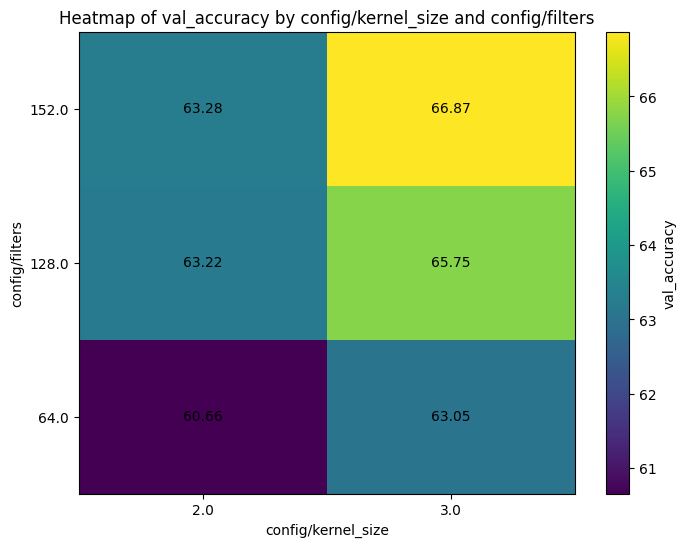

In [20]:
plot_heatmap(
    tune_df,
    x="config/kernel_size",
    y="config/filters",
    z="val_accuracy"
)


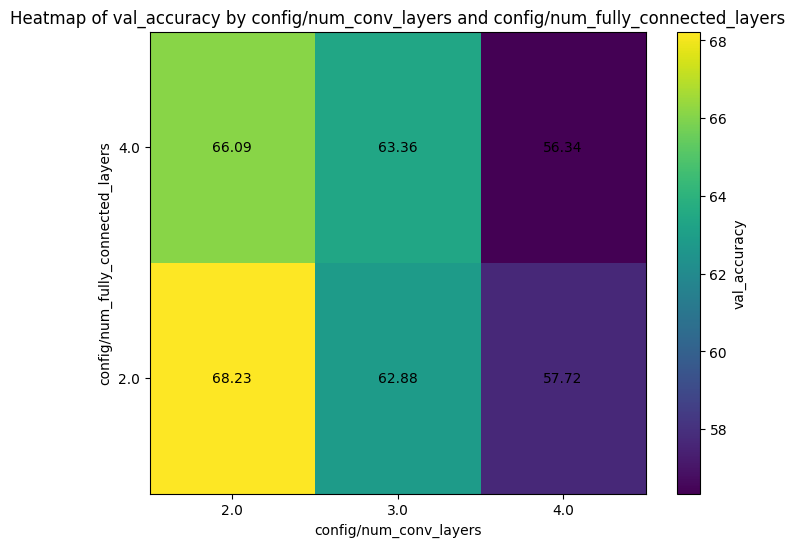

In [21]:
plot_heatmap(
    tune_df,
    x="config/num_conv_layers",
    y="config/num_fully_connected_layers",
    z="val_accuracy",
)

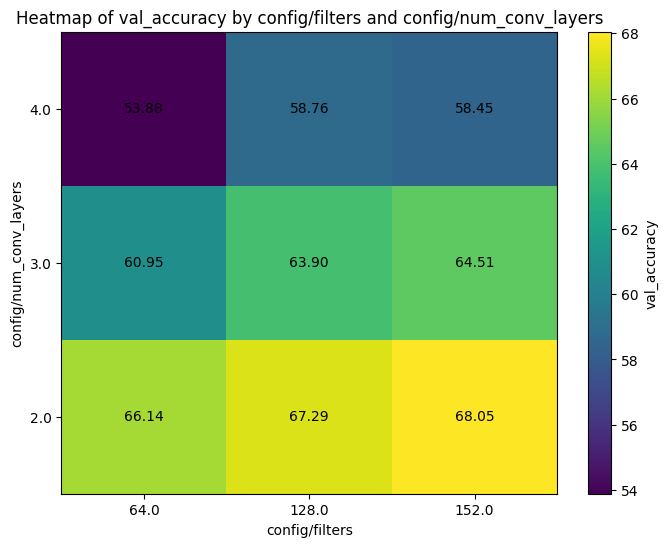

In [22]:
plot_heatmap(
    tune_df,
    x="config/filters",
    y="config/num_conv_layers",
    z="val_accuracy",
)

In [23]:
tune_df.sort_values("val_accuracy", ascending=False)

,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
60557_00005,0.865369,0.858346,69.486,69.92,1.760821e+09,NaN,True,3.0,2025-10-18_22-54-02,403.648981,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,3.0,1.0,0.0
60557_00001,0.892391,0.906145,68.366,68.94,1.760820e+09,NaN,True,3.0,2025-10-18_22-47-15,446.464680,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,2.0,1.0,0.0
60557_00023,0.929347,0.921948,67.404,68.42,1.760821e+09,NaN,True,3.0,2025-10-18_22-52-50,349.034162,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,3.0,1.0,0.0
60557_00002,0.874895,0.901638,69.040,68.35,1.760821e+09,NaN,True,3.0,2025-10-18_22-51-57,444.569682,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,2.0,1.0,0.0
60557_00004,0.881966,0.905660,69.082,68.30,1.760821e+09,NaN,True,3.0,2025-10-18_22-48-29,448.493500,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,3.0,1.0,0.0
60557_00022,0.924181,0.918177,67.724,67.77,1.760821e+09,NaN,True,3.0,2025-10-18_22-49-01,425.717222,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,3.0,1.0,0.0
60557_00000,0.927062,0.930176,67.220,67.49,1.760816e+09,NaN,True,3.0,2025-10-18_21-32-53,241.713299,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,64.0,2.0,1.0,0.0
60557_00003,0.984557,0.966020,65.202,66.37,1.760816e+09,NaN,True,3.0,2025-10-18_21-33-31,244.656201,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,64.0,3.0,1.0,0.0
60557_00021,0.986069,0.977975,64.850,66.36,1.760816e+09,NaN,True,3.0,2025-10-18_21-33-55,239.280859,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,64.0,3.0,1.0,0.0


In [24]:
from ray.tune.schedulers import AsyncHyperBandScheduler

config_hyperband = {
    # Fixed parameters
    "epochs": 10,
    "data_dir": Path(DATADIR).resolve(),
    "tune_dir": Path(TUNEDIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 20,
    "hidden_size": tune.randint(254, 512),
    "dropout": 0,
    "num_fully_connected_layers": 2,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # convolutional layer parameters
    "num_conv_layers": tune.grid_search([3]),
    "filters": tune.randint(100, 200),
    "kernel_size": tune.randint(2, 3),
    "stride": 1,
    "padding": tune.randint(0, 1),  # typical options for padding
}

# Create an AsyncHyperBandScheduler for efficient hyperparameter search
scheduler_hyperband = AsyncHyperBandScheduler(
    time_attr="training_iteration",  # attribute that tracks training progress
    grace_period=3,                  # start terminating after 3 epochs
    reduction_factor=2,              # half the number of models per epoch after grace_period
    max_t=config_hyperband["epochs"] # train for max 10 epochs
)

analysis = tune.run(
    train_and_evaluate_ray,
    config=config_hyperband,
    name="cnn_hyperparameter_hyperband",
    metric="val_loss",
    mode="min",
    storage_path=str(config_hyperband["tune_dir"]),  # ensure path is string
    num_samples=20,
    verbose=1,
    scheduler=scheduler_hyperband,
    resume=True
)
tune_df_hyperband = analysis.results_df.sort_values("val_loss")
tune_df_hyperband.head()


2025-10-19 16:09:24,797	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-10-19_14-42-37.json
2025-10-19 16:09:25,008	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune/cnn_hyperparameter_hyperband' in 0.0677s.
2025-10-19 16:09:25,021	INFO tune.py:1041 -- Total run time: 0.24 seconds (0.00 seconds for the tuning loop).


,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
c2308_00004,0.572131,0.815768,79.694,72.23,1760873360,None,True,10,2025-10-19_13-29-20,225.444769,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,100,2,1,0
c2308_00008,0.391925,0.840546,85.932,73.82,1760875787,None,True,10,2025-10-19_14-09-47,264.145192,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,191,2,1,0
c2308_00007,0.428741,0.840812,84.690,73.46,1760875246,None,True,10,2025-10-19_14-00-46,320.453449,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,174,2,1,0
c2308_00002,0.479114,0.841691,82.956,72.65,1760874488,None,True,10,2025-10-19_13-48-08,258.529060,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,143,2,1,0
c2308_00019,0.460384,0.845245,83.786,72.95,1760873759,None,True,10,2025-10-19_13-35-59,246.382710,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,122,2,1,0


In [25]:
best = analysis.get_best_config()
best

{'epochs': 10,
 'data_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10'),
 'tune_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune'),
 'batch_size': 64,
 'input_size': 3,
 'output_size': 20,
 'hidden_size': 378,
 'dropout': 0,
 'num_fully_connected_layers': 2,
 'learning_rate': 0.001,
 'loss_fn': CrossEntropyLoss(),
 'optimizer': torch.optim.adam.Adam,
 'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'metrics': 'accuracy',
 'device': 'cpu',
 'num_conv_layers': 3,
 'filters': 100,
 'kernel_size': 2,
 'stride': 1,
 'padding': 0}

2025-10-19 16:09:25.237 | INFO     | __main__:<module>:6 - Best config: {'epochs': 10, 'data_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10'), 'tune_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune'), 'batch_size': 64, 'input_size': 3, 'output_size': 20, 'hidden_size': 378, 'dropout': 0, 'num_fully_connected_layers': 2, 'learning_rate': 0.001, 'loss_fn': CrossEntropyLoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'metrics': 'accuracy', 'device': 'cpu', 'num_conv_layers': 3, 'filters': 100, 'kernel_size': 2, 'stride': 1, 'padding': 0}
2025-10-19 16:09:25,248	ERROR experiment_analysis.py:467 -- No checkpoints have been found for trial train_and_evaluate_ray_c2308_00004.
Training: 100%|██████████| 782/782 [00:28<00:00, 27.18it/s]
2025-10-19 16:10:02.305 | INFO     | __main__:train_and_e

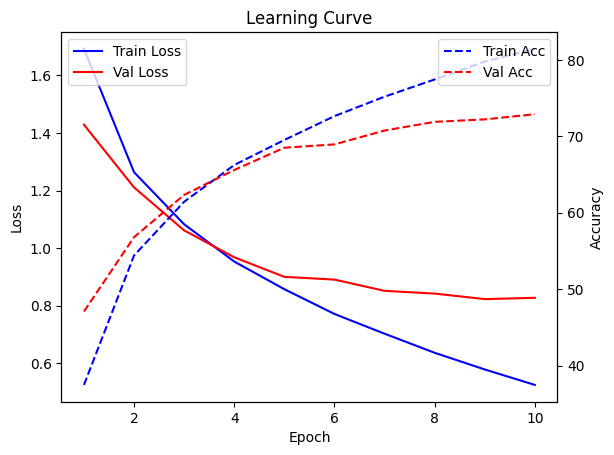

In [26]:
import torch

# Get the best config from the hyperband search
best_config = analysis.get_best_config(metric="val_loss", mode="min")

logger.info(f"Best config: {best_config}")

# Instantiate the model with the best hyperparameters
best_model = SimpleCNN(
    input_size=best_config["input_size"],
    hidden_size=best_config["hidden_size"],
    output_size=best_config["output_size"],
    dropout=best_config["dropout"],
    num_conv_layers=best_config["num_conv_layers"],
    filters=best_config["filters"],
    kernel_size=best_config["kernel_size"],
    stride=best_config["stride"],
    padding=best_config["padding"],
    num_fully_connected_layers=best_config["num_fully_connected_layers"]
)

# Move model to device
device = best_config["device"]
best_model.to(device)

# Optionally, you can load weights from a checkpoint if available:
checkpoint_path = analysis.get_best_checkpoint(trial=analysis.get_best_trial(metric="val_loss", mode="min"))
if checkpoint_path:
    best_model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])

# Now you can further train the model using your existing train_and_evaluate function:
# Example:
train_and_evaluate(best_model, best_config, logger)
best_model.plot_learning_curve()

In [27]:
def train_and_evaluate(model, config, logger):
    train_loader, test_loader = get_data_loaders_transforms(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_accuracy = evaluate(model, test_loader, loss_fn, device)

        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)

        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")
    
    return model.train_losses[-1], model.val_losses[-1], model.val_accuracies[-1]

In [ ]:
from ray.tune.schedulers import AsyncHyperBandScheduler

config_hyperband = {
    # Fixed parameters
    "epochs": 10,
    "data_dir": Path(DATADIR).resolve(),
    "tune_dir": Path(TUNEDIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 20,
    "hidden_size": tune.randint(254, 512),
    "dropout": 0,
    "num_fully_connected_layers": 2,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # convolutional layer parameters
    "num_conv_layers": tune.grid_search([3]),
    "filters": tune.randint(100, 200),
    "kernel_size": tune.randint(2, 3),
    "stride": 1,
    "padding": tune.randint(0, 1),  # typical options for padding
}

# Create an AsyncHyperBandScheduler for efficient hyperparameter search
scheduler_hyperband = AsyncHyperBandScheduler(
    time_attr="training_iteration",  # attribute that tracks training progress
    grace_period=3,                  # start terminating after 3 epochs
    reduction_factor=2,              # half the number of models per epoch after grace_period
    max_t=config_hyperband["epochs"] # train for max 10 epochs
)

# To avoid running out of memory, set 'reuse_actors' to True and limit 'max_concurrent_trials'.
# You can also reduce 'num_samples' or batch size if needed.

analysis = tune.run(
    train_and_evaluate_ray,
    config=config_hyperband,
    name="cnn_hyperparameter_hyperband_transforms",
    metric="val_loss",
    mode="min",
    storage_path=str(config_hyperband["tune_dir"]),  # ensure path is string
    num_samples=20,
    verbose=1,
    scheduler=scheduler_hyperband,
    resume=True,
    reuse_actors=True,              # Reuse actors to save memory
    max_concurrent_trials=5         # Limit concurrent trials (adjust as needed)
)
tune_df_hyperband = analysis.results_df.sort_values("val_loss")
tune_df_hyperband.head()


2025-10-19 16:47:16,350	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-10-19_16-30-59.json


In [ ]:
import torch

# Get the best config from the hyperband search
best_config = analysis.get_best_config(metric="val_loss", mode="min")

logger.info(f"Best config: {best_config}")

# Instantiate the model with the best hyperparameters
best_model = SimpleCNN(
    input_size=best_config["input_size"],
    hidden_size=best_config["hidden_size"],
    output_size=best_config["output_size"],
    dropout=best_config["dropout"],
    num_conv_layers=best_config["num_conv_layers"],
    filters=best_config["filters"],
    kernel_size=best_config["kernel_size"],
    stride=best_config["stride"],
    padding=best_config["padding"],
    num_fully_connected_layers=best_config["num_fully_connected_layers"]
)

# Move model to device
device = best_config["device"]
best_model.to(device)

# Optionally, you can load weights from a checkpoint if available:
checkpoint_path = analysis.get_best_checkpoint(trial=analysis.get_best_trial(metric="val_loss", mode="min"))
if checkpoint_path:
    best_model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])

# Now you can further train the model using your existing train_and_evaluate function:
# Example:
train_and_evaluate(best_model, best_config, logger)
best_model.plot_learning_curve()